<a href="https://colab.research.google.com/github/Shrey-Viradiya/ML_DL/blob/master/Pneumonia_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Classification Using Keras

In [1]:
!nvidia-smi

Fri Jun 19 08:23:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Upload your kaggle token (i.e. kaggle.json) and then run it.

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
![! -d './chest_xray/'] && unzip chest-xray-pneumonia.zip

/bin/bash: [!: command not found


In [5]:
!rm -r chest_xray/chest_xray/ -f
!rm -r chest_xray/__MACOSX/ -f

### Dataset available at: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

Importing Libraries

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras

In [7]:
tf.keras.backend.set_floatx(
    'float16'
)

In [8]:
train_directory = 'chest_xray/train/'
test_directory = 'chest_xray/test/'
valid_directory = 'chest_xray/val/'

## Exploring data

Let's plot some random images
-----------------------------


Text(0.5, 1.0, 'person1611_bacteria_4241.jpeg')

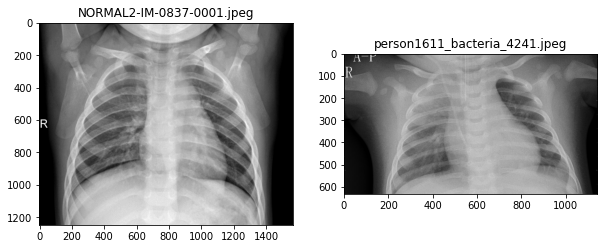

In [9]:
import os
from PIL import Image

print("Let's plot some random images")
print("-----------------------------")

images = os.listdir(train_directory+'NORMAL')
name1 = images[np.random.randint(0,len(images))]
path1 = train_directory + "NORMAL/" + name1

images = os.listdir(train_directory+'PNEUMONIA')
name2 = images[np.random.randint(0,len(images))]
path2 = train_directory + "PNEUMONIA/" + name2

plt.figure(figsize= (10,6))

plt.subplot(121)
plt.imshow(Image.open(path1), cmap='gray')
plt.title(name1)

plt.subplot(122)
plt.imshow(Image.open(path2), cmap='gray')
plt.title(name2)

## Creating ImageDataGenerators

In [10]:
target_size = (226,226)

In [11]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=target_size,
    batch_size=128,
    class_mode='categorical',
)

Found 5216 images belonging to 2 classes.


In [12]:
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip=True)
test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=target_size,
    batch_size=128,
    class_mode='categorical'
)

Found 624 images belonging to 2 classes.


In [13]:
valid_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip=True)
valid_generator = valid_datagen.flow_from_directory(
    valid_directory,
    target_size=target_size,
    batch_size=128,
    class_mode='categorical'
)

Found 16 images belonging to 2 classes.


In [14]:
train_generator.image_shape

(226, 226, 3)

In [15]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

### Creating Model

Test Model 1

In [16]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters = 64, kernel_size = 7, input_shape=train_generator.image_shape),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=2, activation='softmax')
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 226, 226, 64)      9472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 113, 113, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 113, 113, 128)     73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 113, 113, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       5

In [18]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping_monitor = keras.callbacks.EarlyStopping(patience = 3)
history = model.fit(train_generator, validation_data = valid_generator, callbacks = [early_stopping_monitor],epochs= 15)

TypeError: ignored

Test Model 2

In [ ]:
model = keras.models.Sequential([
                                 keras.layers.Conv2D(64, kernel_size=3, activation = 'relu', padding='SAME', input_shape = train_generator.image_shape),
                                 keras.layers.MaxPooling2D(2),
                                 keras.layers.Conv2D(64, kernel_size=3, activation = 'relu', padding='SAME'),
                                 keras.layers.MaxPooling2D(2),
                                 keras.layers.Flatten(),
                                 keras.layers.Dense(128, activation='relu'),
                                 keras.layers.Dropout(0.3),
                                 keras.layers.Dense(64, activation='relu'),
                                 keras.layers.Dropout(0.3),
                                 keras.layers.Dense(2, activation = 'softmax')
])

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping_monitor = keras.callbacks.EarlyStopping(patience = 3)
history = model.fit(train_generator, validation_data = valid_generator, callbacks = [early_stopping_monitor],epochs= 15)

In [ ]:
model.evaluate(test_generator)

In [ ]:
prediction = model.predict(train_generator)

Model Based on Alex net

In [ ]:
model = keras.models.Sequential([
                keras.layers.Conv2D(96, kernel_size=11, strides = 4,activation = 'relu', padding='VALID', input_shape = train_generator.image_shape),
                keras.layers.MaxPooling2D(2, strides=2),
                keras.layers.Conv2D(256, kernel_size=5, strides=1, activation = 'relu', padding='SAME'),
                keras.layers.MaxPooling2D(2, strides=2),
                keras.layers.Conv2D(384, kernel_size=3, strides=1, activation = 'relu', padding='SAME'),
                keras.layers.Conv2D(384, kernel_size=3, strides=1, activation = 'relu', padding='SAME'),
                keras.layers.Conv2D(256, kernel_size=3, strides=1, activation = 'relu', padding='SAME'),
                keras.layers.MaxPooling2D(2, strides=2),
                keras.layers.Flatten(),
                keras.layers.Dense(units = 4096, activation='relu'),
                keras.layers.Dropout(0.5),
                keras.layers.Dense(units = 4096, activation='relu'),
                keras.layers.Dropout(0.5),
                keras.layers.Dense(units = 2, activation='softmax')
])

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping_monitor = keras.callbacks.EarlyStopping(patience = 3)
history = model.fit(train_generator, validation_data = valid_generator, callbacks = [early_stopping_monitor],epochs= 15)

Test Model 4

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.ZeroPadding2D((1,1),input_shape=train_generator.image_shape))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2), strides=(2,2)))

model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2), strides=(2,2)))

model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2), strides=(2,2)))

model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Conv2D(512, (3, 3), activation='relu'))
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Conv2D(512, (3, 3), activation='relu'))
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Conv2D(512, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2), strides=(2,2)))

model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Conv2D(512, (3, 3), activation='relu'))
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Conv2D(512, (3, 3), activation='relu'))
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Conv2D(512, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2), strides=(2,2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(4096, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(4096, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(2, activation='softmax'))

In [ ]:
model.summary()

In [ ]:
optimizer = keras.optimizers.Adam(lr = 0.001)
early_stopping_monitor = keras.callbacks.EarlyStopping(patience = 3)
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
history = model.fit(train_generator,epochs=5, callbacks=[early_stopping_monitor], shuffle=True, validation_data=valid_generator)
prediction = model.predict(train_generator)

In [ ]:
!nvidia-smi